In [3]:
import os
import re
import pandas as pd
from datetime import datetime
import urllib.request

import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.types import *
import pyspark.sql.functions as psf

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline

os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.10:0.4.1 pyspark-shell'

In [4]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.session.timeZone', 'UTC')
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [5]:
style_dic = {'axes.axisbelow': True,
             'axes.edgecolor': '.8',
             'axes.facecolor': '.9',
             'axes.grid': True,
             'axes.labelcolor': '.15',
             'axes.spines.bottom': True,
             'axes.spines.left': True,
             'axes.spines.right': True,
             'axes.spines.top': True,
             'figure.facecolor': 'white',
             'font.family': ['sans-serif'],
             'font.sans-serif': ['Arial',
                                 'DejaVu Sans',
                                 'Liberation Sans',
                                 'Bitstream Vera Sans',
                                 'sans-serif'],
             'grid.color': '.8',
             'grid.linestyle': '-',
             'image.cmap': 'rocket',
             'lines.solid_capstyle': 'round',
             'patch.edgecolor': 'w',
             'patch.force_edgecolor': False,
             'text.color': '.15',
             'xtick.bottom': True,
             'xtick.color': '.15',
             'xtick.direction': 'out',
             'xtick.top': False,
             'ytick.color': '.15',
             'ytick.direction': 'out',
             'ytick.left': True,
             'ytick.right': False}

sns.set_style(style_dic);
# set font size 
sns.set(font_scale=2)

# Load Data

In [ ]:
dir_data_opensub = 'parquets/'

In [ ]:
df_sp0 = spark.read.parquet(dir_data_opensub+'films.parquet')
df_ratings = spark.read.parquet('ratings.parquet')
df_basics = spark.read.parquet('basics.parquet')

In [ ]:
df_sp0.count()

In [ ]:
s_sp = df_sp0.take(2)
s_ratings = df_ratings.take(2)
s_basics = df_basics.take(2)

In [ ]:
s_basics

In [ ]:
df_join = df_sp0.join(other=df_basics,
                     on='tconst',
                     how='inner')

### Drop columns and convert to pandas 

In [ ]:
cols = df_join.columns 

In [ ]:
print(cols)

In [ ]:
# remove columns from dropping list
cols.remove('tconst')
cols.remove('year')
cols.remove('genres')

In [ ]:
# 
df_sp1 = df_join
for col in cols: 
    df_sp1 = df_sp1.drop(col)

In [ ]:
df_sp1.show()

explode "genres" column 

In [ ]:
df_sp2 = df_sp1.select("tconst", "year", psf.explode_outer("genres")).withColumnRenamed('col', 'genre')

In [ ]:
# convert to pandas 
df_pd1 = df_sp2.toPandas()

In [ ]:
df_pd1.head()

# Graphs 

In [ ]:
counts_genres = df_pd1.groupby(['genre']).size()
counts_genres

In [ ]:
counts_genres = counts_genres.sort_values(ascending=True).reset_index().rename(columns={0:'counts'})

In [ ]:
counts_genres.head()

In [ ]:
# to change aspect of the plots to look like latex

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix';
matplotlib.rcParams['font.family'] = 'STIXGeneral';
# matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$');

In [ ]:
# choose number of genres to plot 
n = 10
top5_genres = counts_genres[-n:]
hfont = {'fontname':'Times New Roman'}
plt.figure(figsize=(10,5))
plt.title('Top 10 genre-tags present in the dataset', {'fontsize':14}, **hfont)
plt.grid()
positions = np.arange(len(top5_genres))
plt.barh(positions,
         width=top5_genres['counts'],
         align='center',
         color='black')
plt.yticks(positions,
           top5_genres['genre'],
           fontsize=14);
plt.xticks(fontsize=14)
ax = plt.gca()
ax.set_facecolor((224/255, 224/255, 224/255))


## Scatter plots by genre 

#### Start fresh 

In [ ]:
dir_data_opensub = 'parquets/'

In [ ]:
df_sp0 = spark.read.parquet(dir_data_opensub+'films.parquet')
df_ratings = spark.read.parquet('ratings.parquet')
df_basics = spark.read.parquet('basics.parquet')

In [ ]:
def word_statistics(df_films):
    df_words = df_films.select('*', psf.explode('subtitles').alias('words'))
    df_words = df_words.select('*', psf.explode('words').alias('word'))
    df_word_counts = df_words.groupby("tconst", "num_sentences", "blocks", "subtitle_mins")\
                             .agg(psf.count("word").alias("Number of words"), 
                                  psf.countDistinct("word").alias("Number of distinct words"))\
                             .withColumn("Mean length of sentences",
                                         psf.col("Number of words") / psf.col("num_sentences"))\
                             .withColumn("Spread of sentences",
                                         psf.col("num_sentences") / psf.col("blocks"))
    return df_word_counts

#### Create df for word statistics : 

In [ ]:
df_word_stats = spark.read.parquet('stats.parquet')

In [ ]:
df_word_stats.show()

#### Get tconst for filtering 

In [ ]:
df_tconst = df_sp0.select('tconst')

#### Filter imdb basics data 

In [ ]:
df_basics.count()

In [ ]:
df_basics_F = df_tconst.join(other=df_basics, 
                             on='tconst', 
                             how='inner') 

In [ ]:
df_basics_F.count()

#### Get genre for each imdb-id

In [ ]:
df_basics.columns 

#### Explode genres into genre

In [ ]:
# take only the genre column and tconst and explode genres into genre
df_genre = df_basics_F.select('tconst',psf.explode_outer('genres'))\
                      .withColumnRenamed('col', 'genre')

In [ ]:
df_genre.show()

#### Counting the number of entries in `df_genres`: 

In [ ]:
df_genre.count()

#### Join with df_w_stats

In [ ]:
# explode genres column
df_w_join = df_word_stats.join(other=df_genre, 
                               on='tconst',
                               how='inner')


In [ ]:
df_w_join.count()

#### Join with ratings 

In [ ]:
df_genre_scat = df_w_join.join(other=df_ratings,
                               on='tconst', 
                               how='inner')

In [ ]:
df_genre_scat.count()

### Plots for top 10 genres

#### Convert da shit to pandas homie 


In [ ]:
df_pd = df_genre_scat.toPandas() 

In [ ]:
df_pd.head()

In [ ]:
print(df_pd.columns)

### Top 10 genres : 

In [ ]:
fplot = False

In [ ]:
def scatter_plotter(df,fg=True,genre='Drama'): 
    
    if fg: 
        df_g = df[df['genre'] == genre]
    else: 
        df_g = df 
    
    ax = df_g.plot.scatter("num_sentences","averageRating")
    ax = df_g.plot.scatter("blocks", "averageRating")
    ax = df_g.plot.scatter("subtitle_mins", "averageRating")
    
    ax = df_g.plot.scatter("num_words", "averageRating")
    ax = df_g.plot.scatter("num_distinct_words", "averageRating")
    
    ax = df_g.plot.scatter("words_per_min", "averageRating")
    ax = df_g.plot.scatter("sentences_per_min", "averageRating")
    
    
    ax = df_g.plot.scatter("mean_length_sentences", "averageRating")
    ax = df_g.plot.scatter("distinct_words_per_min", "averageRating")
    ax = df_g.plot.scatter("distinct_words_per_sentence", "averageRating")
    
    ax = df_g.plot.scatter("sentences_spread", "averageRating")
    ax = df_g.plot.scatter("subtitle_mins_perc", "averageRating")
    plt.xlim(0,100)
    

In [ ]:
df_pd.columns 

###### Plots for Drama 

In [ ]:
scatter_plotter(df_pd,genre='Drama')

#### Plots for Comedy

In [ ]:
scatter_plotter(df_pd,genre='Comedy')

#### Plots for Action

In [ ]:
scatter_plotter(df_pd,genre='Action')

#### Plots for Crime

In [ ]:
scatter_plotter(df_pd,genre='Crime')

#### Plots for Romance 

In [ ]:
scatter_plotter(df_pd,genre='Romance')

#### Plots for Thriller

In [ ]:
scatter_plotter(df_pd,genre='Thriller')

#### Plots for Adventure

In [ ]:
scatter_plotter(df_pd,genre='Adventure')

#### Plots for Horror

In [ ]:
scatter_plotter(df_pd,genre='Horror')

#### Plots for Mystery

In [ ]:
scatter_plotter(df_pd,genre='Mystery')

#### Plots for Fantasy

In [ ]:
scatter_plotter(df_pd,genre='Fantasy')

### New plots 

In [7]:
# load data 
df_sp0 = spark.read.parquet('parquets/films.parquet')
df_rat0 = spark.read.parquet('ratings.parquet')
df_bas0 = spark.read.parquet('basics.parquet')
df_st0 = spark.read.parquet('parquets/stats.parquet')

In [9]:
# dropping columns 
df_st0d = df_st0.drop('blocks')
df_st0d = df_st0d.drop('words_per_min')
df_st0d = df_st0d.drop('sentences_per_min')
df_st0d = df_st0d.drop('distinct_words_per_min')
df_st0d = df_st0d.drop('distinct_words_per_sentence')
df_st0d = df_st0d.drop('sentences_spread')
df_st0d = df_st0d.drop('subtitle_mins_perc')
df_st0d = df_st0d.drop('subtitles')

In [37]:
df_rat0.columns 

['tconst', 'averageRating', 'numVotes']

In [10]:
df_st0d.columns

['tconst',
 'num_sentences',
 'subtitle_mins',
 'num_words',
 'num_distinct_words',
 'mean_length_sentences']

In [11]:
df_bas0.columns 

['tconst',
 'titleType',
 'primaryTitle',
 'originalTitle',
 'isAdult',
 'startYear',
 'endYear',
 'runtimeMinutes',
 'genres']

In [12]:
df_bas0d = df_bas0.select('tconst','genres','runtimeMinutes')

In [13]:
df_bas0d.columns 

['tconst', 'genres', 'runtimeMinutes']

In [14]:
df_j0 = df_st0d.join(other=df_bas0d, 
                      on='tconst', 
                      how='inner')

In [43]:
df_j0.columns

['tconst',
 'num_sentences',
 'subtitle_mins',
 'num_words',
 'num_distinct_words',
 'mean_length_sentences',
 'genres',
 'runtimeMinutes']

In [44]:
df_j1 = df_j0.join(other=df_rat0.select('tconst', 'averageRating'), 
                   on='tconst', 
                   how='inner')

In [45]:
df_j1.count()

4275

### Panda Panda

In [49]:
 df_pd = df_j1.toPandas()

In [50]:
df_pd.head()

,tconst,num_sentences,subtitle_mins,num_words,num_distinct_words,mean_length_sentences,genres,runtimeMinutes,averageRating
0,tt0013086,723,206.866667,5515,1498,7.627939,"[Crime, Mystery, Thriller]",242.0,7.9
1,tt0013257,344,44.700000,4110,1291,11.947674,"[Documentary, Fantasy, Horror]",91.0,7.7
2,tt0013442,169,32.650000,1324,586,7.834320,"[Fantasy, Horror]",94.0,8.0
3,tt0015064,15,23.450000,145,113,9.666667,[Drama],77.0,8.1
4,tt0015163,75,NaN,487,299,6.493333,"[Action, Comedy, Romance]",59.0,8.0


In [57]:
df_pd['times ratio'] = df_pd['subtitle_mins']/df_pd['runtimeMinutes']*100

df_pd['distinct_index'] = df_pd['num_distinct_words']/(df_pd['runtimeMinutes']*
                                                       df_pd['num_words']*
                                                       df_pd['mean_length_sentences'])

df_pd['norm_mean_av_s_length'] = df_pd['mean_length_sentences']/df_pd['runtimeMinutes']


In [66]:
def scat_plot(df, col1, col2,figsize=(10,10), xlabel='', ylabel=''): 
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(x=col1,y=col2,data = df,palette='muted');
    plt.xlim = (0,100)
    plt.ylim = (0,10)
    if(xlabel and ylabel):ax.set(xlabel=xlabel,ylabel=ylabel)

### Plot of the mean average length vs average rating :

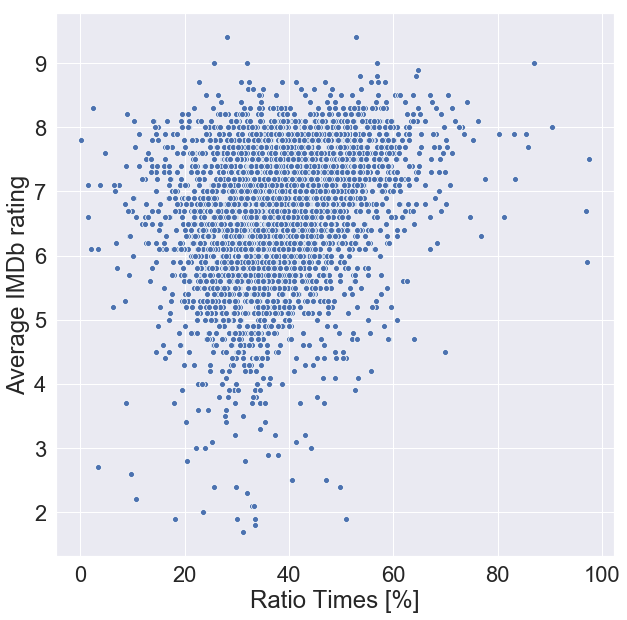

In [67]:
# filter movies that have subtitles times longer than their duration 
df_pd100 = df_pd.drop(df_pd[df_pd['times ratio'] > 100].index, axis=0)


scat_plot(df=df_pd100,
          col1='times ratio',
          col2='averageRating',
          xlabel='Ratio Times [%]', 
          ylabel='Average IMDb rating')

### plot for the distinct-index 

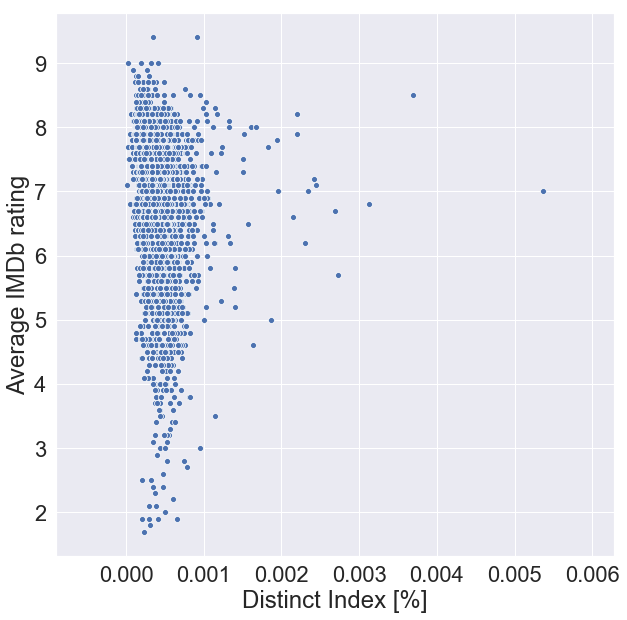

In [69]:
scat_plot(df=df_pd,
          col1='distinct_index',
          col2='averageRating',
          xlabel='Distinct Index [%]', 
          ylabel='Average IMDb rating')

### Plot mean average length 

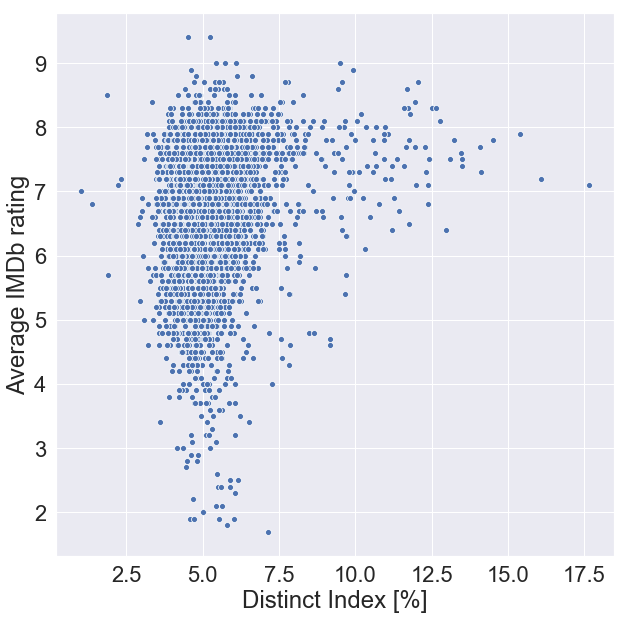

In [72]:
scat_plot(df=df_pd,
          col1='mean_length_sentences',
          col2='averageRating',
          xlabel='Distinct Index [%]', 
          ylabel='Average IMDb rating')

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x='runtimeMinutes',
                y='mean_length_sentences',
                data = df_pd,
                palette='muted');

ax.set(xlabel='Movie Duration',
       ylabel='Mean Sentence Length')

[Text(0,0.5,'Mean Sentence Length'), Text(0.5,0,'Movie Duration')]

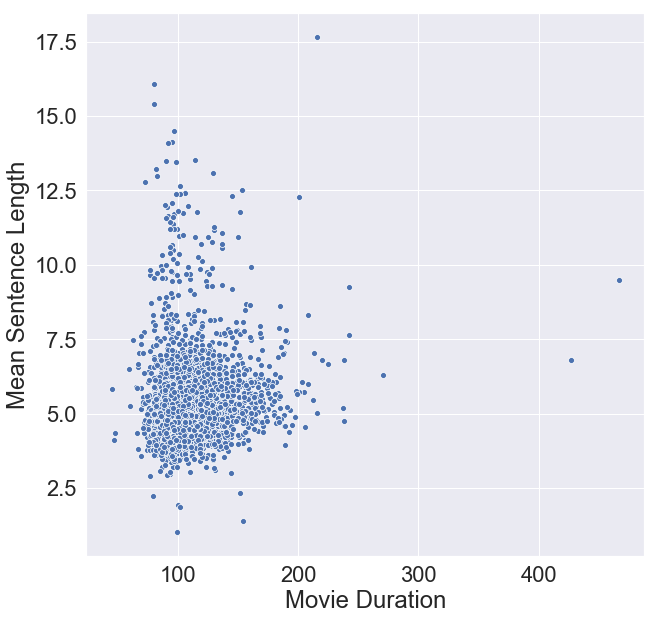

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x='runtimeMinutes',
                y='mean_length_sentences',
                data = df_pd,
                palette='muted');

ax.set(xlabel='Movie Duration',
       ylabel='Mean Sentence Length')

In [ ]:
df_

### investigated mean length 

In [16]:
df_sp0

DataFrame[tconst: string, num_sentences: bigint, year: bigint, blocks: bigint, subtitle_mins: double, subtitles: array<array<string>>]

In [17]:
df = df_st0.select('tconst','mean_length_sentences')\
           .join(other=df_sp0.select('tconst','subtitles'),
                 on='tconst',
                 how='inner')

In [18]:
df_st0.columns

['tconst',
 'num_sentences',
 'blocks',
 'subtitle_mins',
 'num_words',
 'num_distinct_words',
 'words_per_min',
 'sentences_per_min',
 'mean_length_sentences',
 'distinct_words_per_min',
 'distinct_words_per_sentence',
 'sentences_spread',
 'subtitle_mins_perc']

In [19]:
df.columns

['tconst', 'mean_length_sentences', 'subtitles']

In [25]:
dff = df.filter(df.mean_length_sentences <= 5)

In [27]:
dff.head(2)

[Row(tconst='tt0484877', mean_length_sentences=4.422957600827301, subtitles=[['I', 'love', 'love', 'I', 'love', 'being', 'in', 'love'], ['I', 'don', 'care', 'what', 'it', 'does', 'to', 'me'], ['Sing', 'I', 'love', 'love', 'I', 'love', 'being', 'in', 'love'], ['I', 'don', 'care', 'what', 'it', 'does', 'to', 'me'], ['I', 'love', 'love', 'I', 'love', 'being', 'in', 'love'], ['I', 'don', 'care', 'what', 'it', 'does', 'to', 'me'], ['These', 'pills', 'are', 'fine', 'to', 'pass', 'the', 'time', 'til', 'I', 'find', 'my', 'new', 'drug'], ['We', 'take', 'our', 'chances', 'we', 'last', 'a', 'month'], ['We', 'never', 'speak', 'again', 'How', 'I', 'love', 'being', 'in', 'love'], ['May', 'I', 'help', 'you'], ['Huh'], ['No'], ['Thank', 'you'], ['Thank', 'you', 'very', 'much'], ['I', 'just', 'browsing'], ['Thank', 'you'], ['So', 'let', 'me', 'guess'], ['Big', 'night', 'tonight'], ['Yeah'], ['Yeah'], ['Yeah', 'actually'], ['Actually', 'the', 'biggest'], ['Really'], ['Yeah'], ['Menage', 'a', 'trois'], [

In [ ]:
dfpd = df.toPandas() 

In [ ]:
dfpd

In [ ]:
dfpd[dfpd['mean_length_sentences'] <= 3]